## Super resolution

In [109]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from PIL import ImageEnhance
from torchvision.models import vgg16_bn

In [2]:
path = Path('data')
path_org = path/'train'
path_hr = path/'small-512'
path_mr = path/'small-256'

In [3]:
il = ImageList.from_folder(path_org)

In [111]:
image_org = PIL.Image.open('data/train/IMG_1673.JPG')
targ_sz = resize_to(image_org, 512, use_min=True)
image_org = image_org.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
image_org.save('imgs/Original.jpg', quality=100)

targ_sz = resize_to(image_org, 256, use_min=True)
size = image_org.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
targ_sz = resize_to(size, 512, use_min=True)
size = size.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
size.save('imgs/Resolution.jpg', quality=100)

enhancer = ImageEnhance.Brightness(image_org)
enhancer = enhancer.enhance(0.33)
enhancer.save(f'imgs/Brightness.jpg', quality=100)

enhancer = ImageEnhance.Contrast(image_org)
enhancer = enhancer.enhance(0.33)
enhancer.save(f'imgs/Contrast.jpg', quality=100)

enhancer = ImageEnhance.Sharpness(image_org)
enhancer = enhancer.enhance(0.33)
enhancer.save(f'imgs/Sharpness.jpg', quality=100)

image_org.save('imgs/Quality.jpg', quality=30)

In [28]:
def resize_one(fn, i, path, size, change_quality):
    dest = path/fn.relative_to(path_org)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    
    if change_quality:
        enhancer = ImageEnhance.Sharpness(img)
        enhancer = enhancer.enhance(0.5)
        enhancer.save(dest)
        
        enhancer = ImageEnhance.Contrast(PIL.Image.open(dest))
        enhancer = enhancer.enhance(0.5)
        enhancer.save(dest)
        
        enhancer = ImageEnhance.Brightness(PIL.Image.open(dest))
        enhancer = enhancer.enhance(0.5)
        enhancer.save(dest, quality=50)
    else:
        img.save(dest)

In [29]:
# create smaller image sets the first time this nb is run
sets = [(path_mr, 256, True), (path_hr, 512, False)]
for p,size,q in sets:
    if p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size, change_quality=q), il.items)

resizing to 256 into data/small-256


resizing to 512 into data/small-512


In [34]:
bs,size=8,256
arch = models.resnet34

src = ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)

In [35]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [36]:
data = get_data(bs,size)

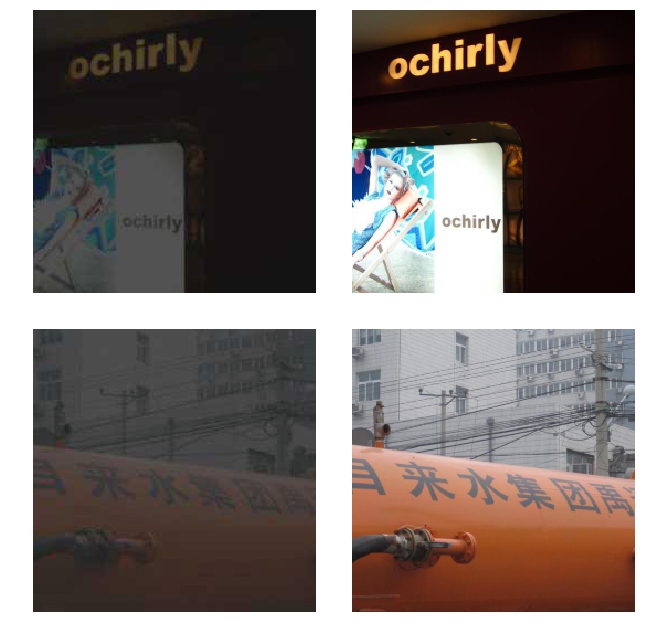

In [37]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [38]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [39]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [40]:
gram_matrix(t)

tensor([[[0.0812, 0.0793, 0.0747],
         [0.0793, 0.0818, 0.0787],
         [0.0747, 0.0787, 0.0777]],

        [[0.0812, 0.0793, 0.0747],
         [0.0793, 0.0818, 0.0787],
         [0.0747, 0.0787, 0.0777]]])

In [41]:
base_loss = F.l1_loss

In [42]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [43]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [44]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [45]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [46]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


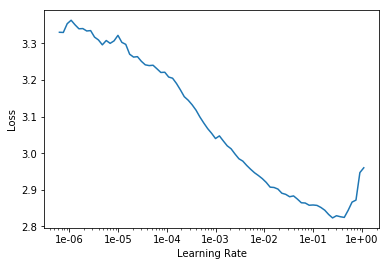

In [47]:
learn.lr_find()
learn.recorder.plot()

In [48]:
lr = 1e-3

In [49]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.520886,2.294132,0.407083,0.254036,0.277660,0.085963,0.532954,0.648313,0.088122,00:40
1,2.347024,2.287577,0.428268,0.246405,0.269363,0.084884,0.530093,0.640678,0.087885,00:37
2,2.301891,2.172410,0.399315,0.236804,0.259000,0.081063,0.502140,0.609171,0.084916,00:37
3,2.263590,2.201120,0.420735,0.238444,0.260830,0.081646,0.508347,0.605366,0.085751,00:37
4,2.232419,2.137438,0.357461,0.237198,0.257948,0.081845,0.510436,0.607723,0.084827,00:37
5,2.207618,2.036689,0.348612,0.229777,0.250407,0.080961,0.468416,0.573961,0.084554,00:37
6,2.222698,2.062699,0.357650,0.230234,0.251134,0.081570,0.472685,0.584267,0.085158,00:37
7,2.164532,2.001331,0.350853,0.226041,0.245227,0.079091,0.461426,0.555360,0.083333,00:37
8,2.129103,1.980160,0.331681,0.227179,0.244418,0.080022,0.452727,0.560163,0.083970,00:37
9,2.072806,1.925667,0.350720,0.222492,0.235788,0.078623,0.437356,0.517109,0.083579,00:37


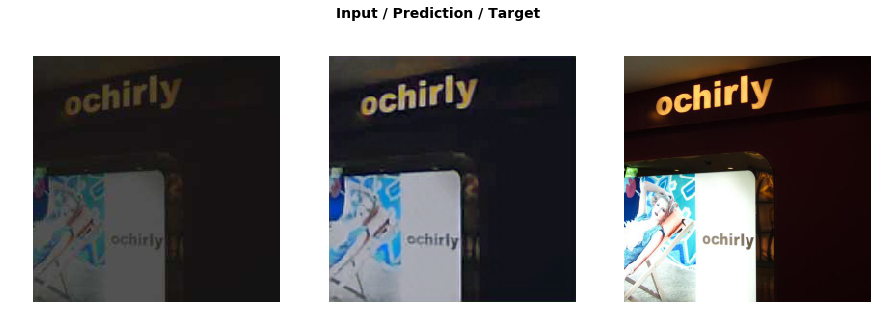

In [50]:
do_fit('1ax', slice(lr*10))

In [51]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.002148,1.879422,0.320193,0.221817,0.234268,0.077915,0.434120,0.508130,0.082978,00:39
1,1.993754,1.856599,0.305147,0.222007,0.233903,0.077353,0.431510,0.504257,0.082422,00:39
2,1.978437,1.835776,0.299431,0.220933,0.232358,0.077270,0.425876,0.497453,0.082454,00:39
3,1.954793,1.819835,0.288705,0.221500,0.232495,0.077519,0.420457,0.496548,0.082611,00:39
4,1.956911,1.823184,0.289563,0.221775,0.233489,0.078407,0.419505,0.496593,0.083852,00:39
5,1.922919,1.779804,0.256717,0.220340,0.231992,0.077788,0.414874,0.495059,0.083035,00:39
6,1.911838,1.808930,0.276905,0.221749,0.233976,0.078306,0.414777,0.500145,0.083072,00:39
7,1.888149,1.797816,0.282484,0.220164,0.231406,0.076613,0.412278,0.493042,0.081828,00:38
8,1.882887,1.779047,0.247918,0.220766,0.233353,0.077572,0.415674,0.501609,0.082157,00:39
9,1.861246,1.730006,0.226951,0.219577,0.231171,0.077524,0.407546,0.484401,0.082835,00:39


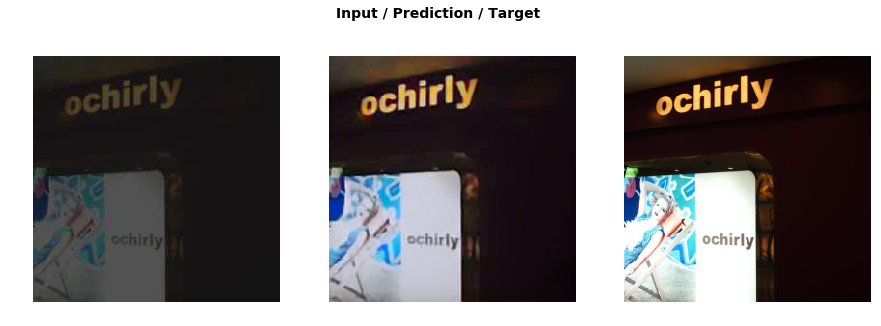

In [52]:
do_fit('1bx', slice(1e-5,lr))

In [53]:
data = get_data(bs//4,size*2)

In [54]:
learn.data = data
learn.freeze()
gc.collect()

18928

In [55]:
learn.load('1b');

/home/paperspace/anaconda3/envs/flasko/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.671207,1.439375,0.239129,0.229631,0.228700,0.057481,0.331274,0.315193,0.037967,02:36
1,1.620406,1.444257,0.249409,0.226777,0.226696,0.055411,0.335841,0.313379,0.036744,02:26
2,1.578029,1.431894,0.237573,0.227497,0.226461,0.055424,0.332840,0.315441,0.036657,02:26
3,1.550229,1.423916,0.224864,0.226627,0.224938,0.054573,0.340548,0.316136,0.036230,02:25
4,1.538454,1.458633,0.264605,0.227259,0.224224,0.054329,0.334543,0.317835,0.035836,02:25
5,1.537704,1.415683,0.239231,0.225689,0.220883,0.054361,0.332704,0.306904,0.035911,02:25
6,1.555964,1.442592,0.255238,0.225689,0.220956,0.053849,0.338846,0.312429,0.035586,02:25
7,1.526347,1.400303,0.236404,0.224063,0.218005,0.054335,0.326564,0.304757,0.036175,02:25
8,1.525433,1.442769,0.280713,0.224759,0.217207,0.054111,0.329840,0.300481,0.035657,02:25
9,1.465225,1.400337,0.247001,0.224708,0.216636,0.053876,0.319602,0.302914,0.035599,02:26


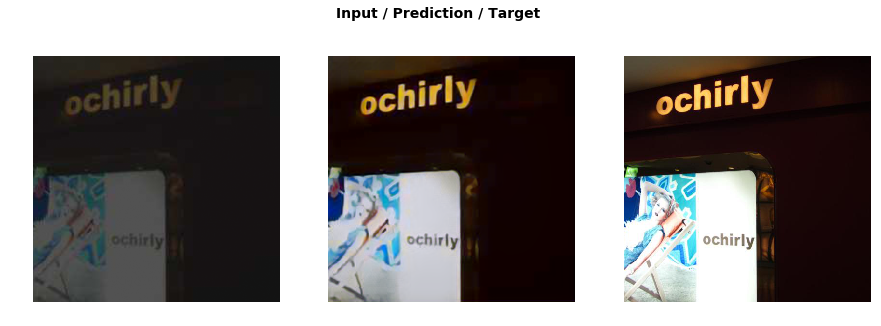

In [56]:
do_fit('2ax')

In [57]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.411498,1.388511,0.225723,0.223806,0.216471,0.053584,0.326342,0.306875,0.035710,02:32
1,1.414233,1.390412,0.241298,0.223222,0.215730,0.053444,0.320626,0.300593,0.035498,02:32
2,1.427501,1.397931,0.247523,0.224745,0.216009,0.053572,0.318638,0.301982,0.035462,02:32
3,1.386912,1.389890,0.245685,0.222975,0.215080,0.053409,0.317391,0.299921,0.035430,02:32
4,1.396550,1.399538,0.255856,0.224091,0.215053,0.053486,0.316753,0.298876,0.035424,02:32
5,1.410457,1.378737,0.229608,0.223609,0.214729,0.053232,0.323541,0.298635,0.035382,02:33
6,1.413822,1.386183,0.232851,0.223686,0.214820,0.053127,0.323553,0.302849,0.035297,02:32
7,1.386293,1.417942,0.271264,0.224824,0.215438,0.053624,0.319737,0.297680,0.035375,02:32
8,1.405500,1.410815,0.261722,0.224035,0.214908,0.053360,0.322784,0.298710,0.035295,02:31
9,1.402320,1.393495,0.238619,0.223475,0.214940,0.053266,0.325185,0.302621,0.035389,02:32


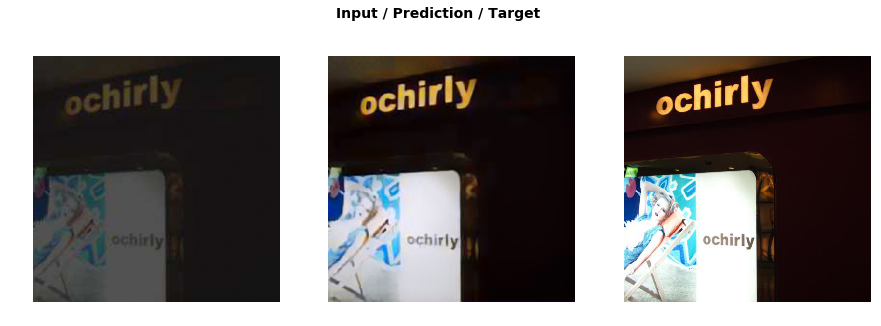

In [58]:
do_fit('2bx', slice(1e-6,1e-4), pct_start=0.3)

## Test

In [59]:
learn = None
gc.collect();

In [60]:
size=( 820, 1024)

In [61]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [62]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_org/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [63]:
learn.load('2b');

In [64]:
learn.data = data_mr

In [102]:
fn = data_mr.valid_ds.x.items[1]; fn

PosixPath('data/small-256/IMG_1770.JPG')

In [103]:
img = open_image(fn); img.shape

torch.Size([3, 256, 341])

In [104]:
p,img_hr,b = learn.predict(img)

## INPUT

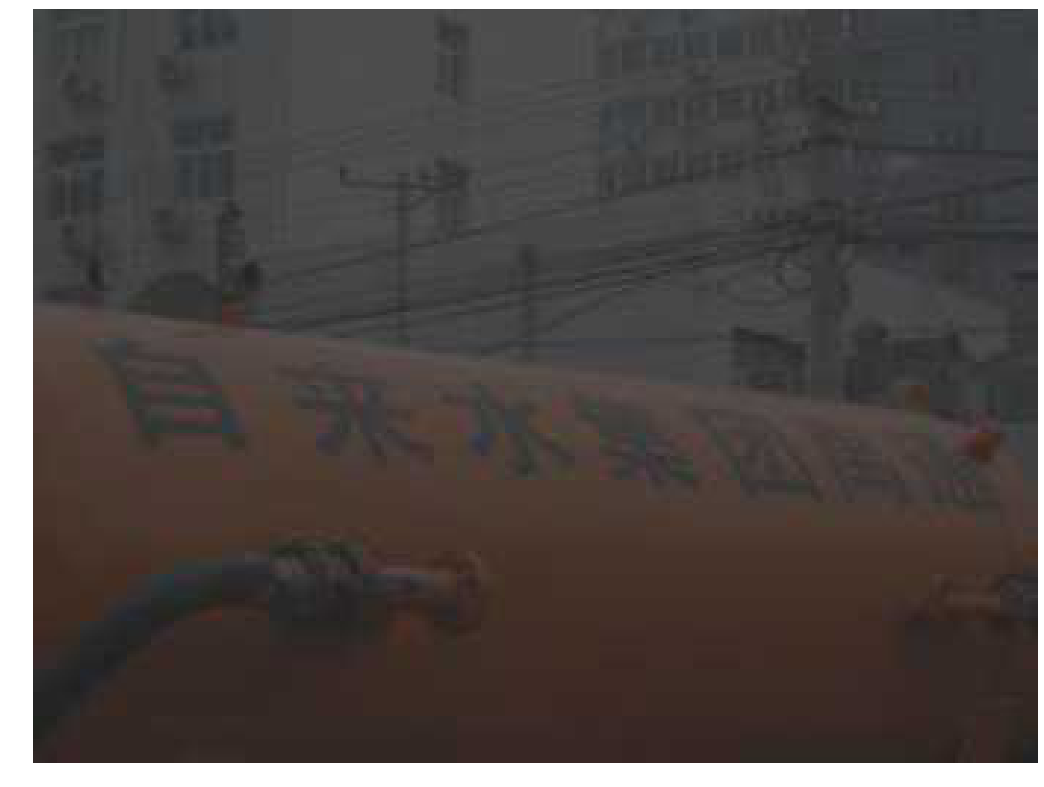

In [105]:
show_image(img, figsize=(18,15), interpolation='nearest');

## Output

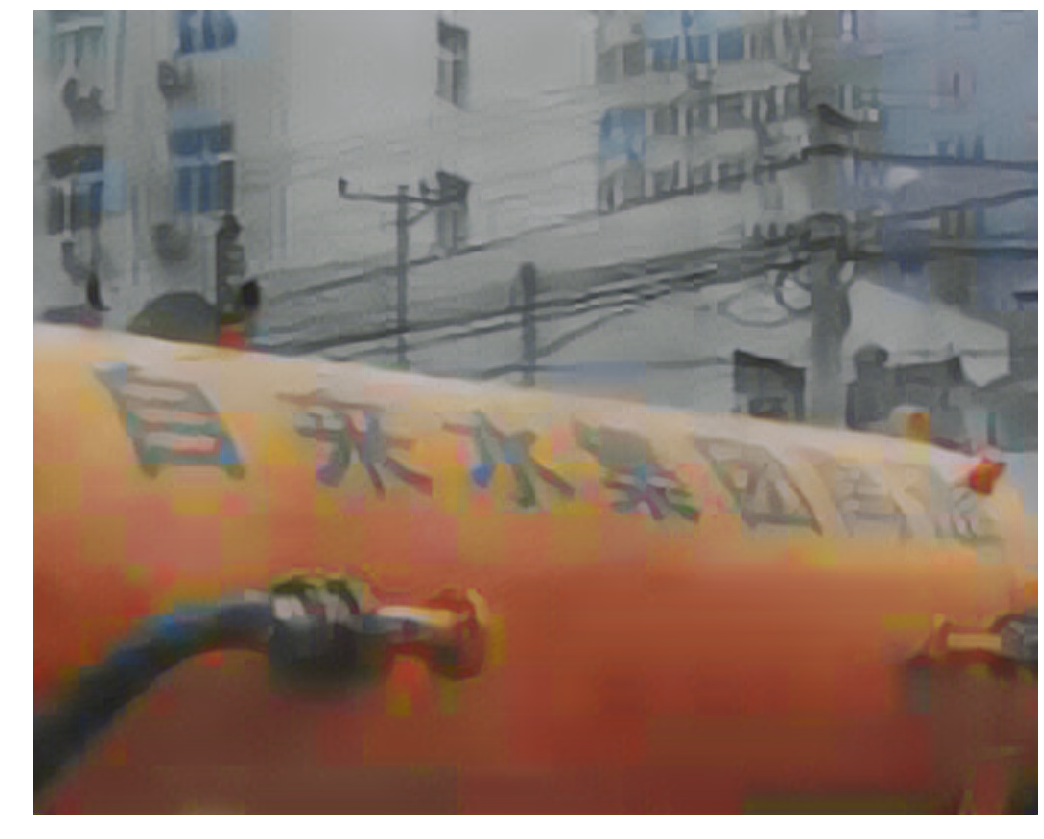

In [106]:
Image(img_hr).show(figsize=(18,15))

## Manually increase brightness

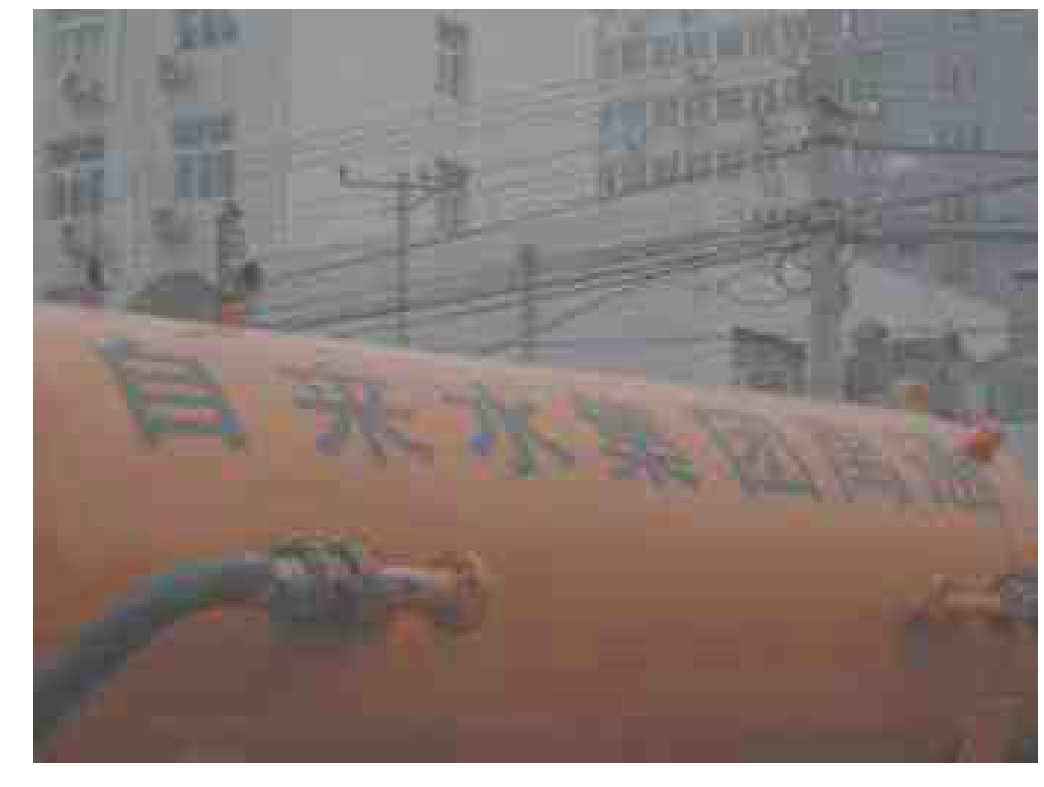

In [107]:
image_org = PIL.Image.open(fn)

enhancer = ImageEnhance.Brightness(image_org)
enhancer = enhancer.enhance(2)
enhancer.save(f'man.jpg', quality=100)

img = open_image('man.jpg')
show_image(img, figsize=(18,15), interpolation='nearest');